# Evaluation pipeline

**GOAL:**

Design a full pipeline for multi-dimensional evaluation of the outputs of a given combination of prompt & LLM for the AUT. 

Inputs:

- outputs of a model with originality and elaboration for the 4 objects for
    - a given LLM (GPTs, open-source models)
    - a given prompt (simple, Few shot prompting, Chain of Thought prompting, ...., RAG)

Ouput:

- graphs, radar charts (1 per object)


### TODO:

- implement a function for elaboration ++

    - elaboration 1: count number of words ✅
    - elaboration 2: count number of words and remove stop words ✅
    - elaboration 3: compute a score with PoS tagging: see with nltk. PoS = technique that involves assigning specific grammatical categories or labels (such as nouns, verbs, adjectives, adverbs, pronouns, etc.) to individual words within a sentence. Idea: a sentence with a lot of adverbs and different verbs is more elaborate that a sentence with one noun and one verb.

- implement a function for flexibility = breadth of categories you cover with your ideas

    - quite linked to similarity measure...
        - see paCy or gensim for word embeddings and similarity calculation.
    - Automated metrics to assess diversity of ideas: BLEU or ROUGE
    - more specifically with topic modelling: gensim or scikit-learn for topic modeling (e.g., LDA, NMF).
    - Compute the information entropy of word distributions within sentences.
    - Measure the lexical richness or complexity of sentences: textstats
    - sentence embeddings and compare distances: transformers

Question: Originality and elaboration are sentence-level evaluation. Is it the same for flexibility ?
    - if yes: need to compute a individual score 
    - if no: topic modeling and clusterization easier with multiple data points

<!-- HTML table for benchmark evaluation -->
<table style="border-collapse: collapse; width: 100%; border: 1px solid black;">
    <thead>
        <tr style="background-color: #f2f2f2;">
            <th style="padding: 8px; border: 1px solid black; text-align: left;">LLM</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Prompt</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Mean Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Std Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Elaboration</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Flexibility</th>
        </tr>
    </thead>
    <tbody>
        <!-- Row 1 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 2 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 3 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 4 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 5 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">Mistral</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>


In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils_benchmark import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [4]:
# Humans
humans = pd.read_csv('./../data/humans_top4_objects.csv')

# GPT-3.5
gpt_35_100 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_35_100.csv')

# GPT-4
gpt_4_100 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_4_100.csv')

# Mistral
mistral = pd.read_csv('./data_ocsai/mistral/ocsai_eval_merged_mistral_30.csv')

objects = list(humans['prompt'].value_counts().head(4).index)

In [6]:
display(humans.head(1), gpt_35_100.head(1), gpt_4_100.head(1), mistral.head(1))

,prompt,response,originality,elaboration
0,rope,use it to tie up a bicycle,1.9,7


,prompt,response,originality,elaboration
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini garden for succulents.,3.0,8.0


,prompt,response,originality,elaboration
0,brick,Use it as a doorstop,1.0,5


## Compute Elaboration

In [38]:
data = {"humans": humans, "gpt_35": gpt_35_100, "gpt_4": gpt_4_100, "mistral": mistral}

for name, df in data.items():
    df = elaboration_SW(df)

display(humans.head(1), gpt_35_100.head(1), gpt_4_100.head(1), mistral.head(1))

,prompt,response,originality,elaboration,elaboration_SW
0,rope,use it to tie up a bicycle,1.9,7,3


,prompt,response,originality,elaboration,elaboration_SW
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0,7


,prompt,response,originality,elaboration,elaboration_SW
0,box,Transform it into a mini garden for succulents.,3.0,8.0,5


,prompt,response,originality,elaboration,elaboration_SW
0,brick,Use it as a doorstop,1.0,5,2


## Compute Flexibility

In [ ]:
# todo

## Visualization

- histplots
- kdeplots
- Radar charts: see code from this [website](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html)

In [21]:
humans_mean_values = humans[["originality", "elaboration", "elaboration_SW"]].mean().values
print(humans_mean_values)
print(humans[humans['prompt'] == 'box'][["originality", "elaboration", "elaboration_SW"]].mean().values)
humans.head()

[1.9013564  4.69904415 2.91770596]
[1.90295967 4.34628191 2.64520903]


,prompt,response,originality,elaboration,elaboration_SW
0,rope,use it to tie up a bicycle,1.9,7,3
1,rope,steps,1.3,1,1
2,rope,dog toy,1.4,2,2
3,box,use it to reach something,1.7,5,3
4,brick,strength tester (punching),2.7,3,5


In [46]:
# normalize the columns originality, elaboration and elaboration_SW
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name in ["originality", "elaboration", "elaboration_SW"]:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

for name, df in data.items():
    data[name] = normalize(df)
    display(data[name].head(1))

,prompt,response,originality,elaboration,elaboration_SW
0,rope,use it to tie up a bicycle,0.225,0.122449,0.130435


,prompt,response,originality,elaboration,elaboration_SW
0,box,Use it as a makeshift stool for reaching high ...,0.28,0.4,0.428571


,prompt,response,originality,elaboration,elaboration_SW
0,box,Transform it into a mini garden for succulents.,0.869565,0.384615,0.25


,prompt,response,originality,elaboration,elaboration_SW
0,brick,Use it as a doorstop,0.0,0.230769,0.0


In [49]:
humans_norm = data['humans']
gpt_35_100_norm = data['gpt_35']
gpt_4_100_norm = data['gpt_4']
mistral_norm = data['mistral']

# check for each dataframe and each column
for name, df in data.items():
    print(name)
    for col in ['originality', 'elaboration', 'elaboration_SW']:
        print(df[col].min(), df[col].max())

humans
0.0 1.0
0.0 1.0
0.0 1.0
gpt_35
0.0 1.0
0.0 1.0
0.0 1.0
gpt_4
0.0 1.0
0.0 1.0
0.0 1.0
mistral
0.0 1.0
0.0 1.0
0.0 1.0


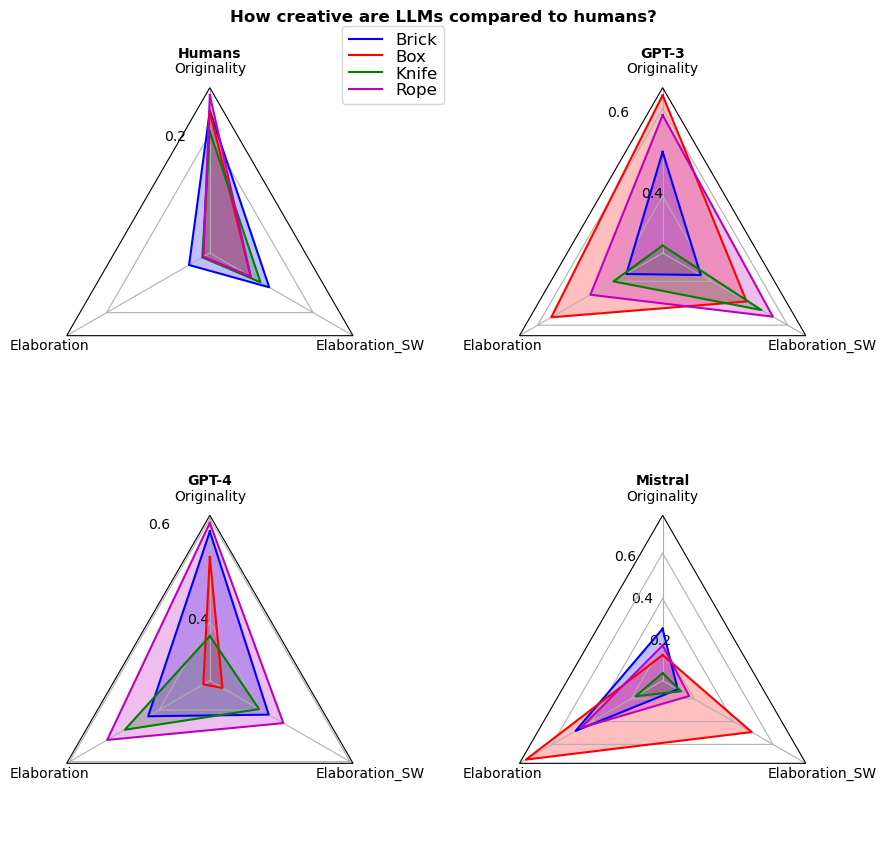

In [50]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():

    data = [
        ['Originality', 'Elaboration', 'Elaboration_SW'],
        ('Humans', [
            humans_norm[humans_norm['prompt'] == 'brick'][["originality", "elaboration", "elaboration_SW"]].mean().values, # brick
            humans_norm[humans_norm['prompt'] == 'box'][["originality", "elaboration", "elaboration_SW"]].mean().values, # box
            humans_norm[humans_norm['prompt'] == 'knife'][["originality", "elaboration", "elaboration_SW"]].mean().values, # knife
            humans_norm[humans_norm['prompt'] == 'rope'][["originality", "elaboration", "elaboration_SW"]].mean().values]), # rope
        ('GPT-3', [
            gpt_35_100_norm[gpt_35_100_norm['prompt'] == 'brick'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            gpt_35_100_norm[gpt_35_100_norm['prompt'] == 'box'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            gpt_35_100_norm[gpt_35_100_norm['prompt'] == 'knife'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            gpt_35_100_norm[gpt_35_100_norm['prompt'] == 'rope'][["originality", "elaboration", "elaboration_SW"]].mean().values]),
        ('GPT-4', [
            gpt_4_100_norm[gpt_4_100_norm['prompt'] == 'brick'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            gpt_4_100_norm[gpt_4_100_norm['prompt'] == 'box'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            gpt_4_100_norm[gpt_4_100_norm['prompt'] == 'knife'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            gpt_4_100_norm[gpt_4_100_norm['prompt'] == 'rope'][["originality", "elaboration", "elaboration_SW"]].mean().values]),
        ('Mistral', [
            mistral_norm[mistral_norm['prompt'] == 'brick'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            mistral_norm[mistral_norm['prompt'] == 'box'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            mistral_norm[mistral_norm['prompt'] == 'knife'][["originality", "elaboration", "elaboration_SW"]].mean().values,
            mistral_norm[mistral_norm['prompt'] == 'rope'][["originality", "elaboration", "elaboration_SW"]].mean().values])
    ]
    return data


if __name__ == '__main__':
    N = 3
    theta = radar_factory(N, frame='polygon')

    data_visu = example_data()
    spoke_labels = data_visu.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data_visu):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        #ax.set_rgrids([1, 2, 3, 4, 5])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Brick', 'Box', 'Knife', 'Rope')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='large')

    fig.text(0.5, 0.965, 'How creative are LLMs compared to humans?',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    plt.tight_layout()
    plt.show()

#